# Сверточная сеть в Keras

На лекции мы узнали, что свертки можно комбинировать, применяя друг за другом. Это увеличивает их рецептивное поле и позволяет выучить более сложные признаки. 

В этом уроке мы с вами обучим нашу первую свертоную нейронную сеть для задачи классификации одежды. Вот как будет выглядеть наш датасет

<img src="https://1.bp.blogspot.com/-AIPR5UuydTY/WbCLlGEmoAI/AAAAAAAAA2U/Teu6q2FF9LslUL6t6Qn5YjzGWNfHC7y7wCLcBGAs/s1600/fashion-mnist-sprite.png" width="600">

Он называется FashionMnist. Название не случайно похоже на Mnist -- с рукописными цифрами -- FashionMnist придумали как замену Mnist, потому что он стал уж слишком простым для современных нейронных сетей. Как вы помните, на нем мы без труда достигли 97-98% точности. 

** перед тем как начать выполнять код мы изменим Runtime на Runtime c GPU. В этом модуле это просто необходимо для ускорения работы*

In [ ]:
import tensorflow as tf
print(tf.__version__)
tf.enable_eager_execution()
import matplotlib.pyplot as plt

1.14.0


In [ ]:
mapping = {0: "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress",
           4: "Coat", 5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag",
           9: "Ankle boot"}  # датасет содержит 10 классов

def show_mnist(images, labels, predicted_labels=None):
    plt.figure(figsize=(10,10))
    for i in range(16):
        plt.subplot(4,4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.gray)
        if predicted_labels is not None:
            title_obj = plt.title(f"Real: {mapping[labels[i]]}. Pred: {mapping[predicted_labels[i]]}")
            if labels[i] != predicted_labels[i]:
                plt.setp(title_obj, color='r')
        else:
            plt.title(f"Real label: {mapping[labels[i]]}")

4423680/4422102 [==============================] - 0s 0us/step
(60000, 28, 28) (10000, 28, 28)


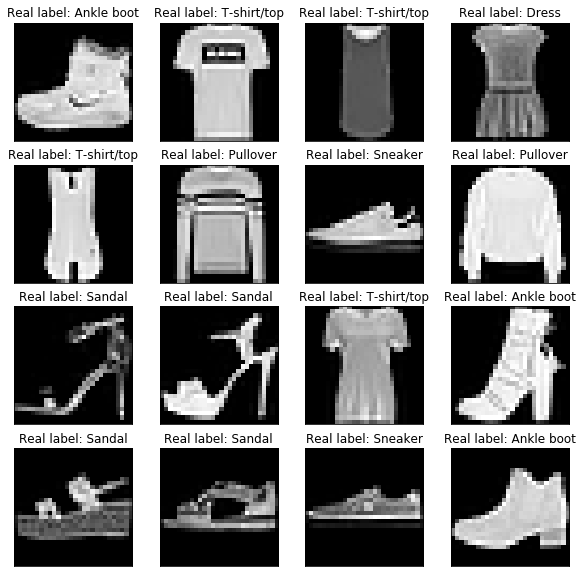

In [ ]:
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

show_mnist(x_train, y_train)
print(x_train.shape, x_test.shape)

Для начала попробуем обучить на новом датасете полносвязную сеть. В точности такую же как мы обучали ранее.

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
  ])

model.summary()
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x=x_train, y=y_train, 
          batch_size=128, epochs=15, 
          validation_data=(x_test, y_test))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples


W0821 12:58:31.846138 140409205168000 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/15
60000/60000 [==============================] - 2s 41us/sample - loss: 0.4999 - acc: 0.8241 - val_loss: 0.4156 - val_acc: 0.8527
Epoch 2/15
60000/60000 [==============================] - 1s 24us/sample - loss: 0.3726 - acc: 0.8665 - val_loss: 0.3783 - val_acc: 0.8663
Epoch 3/15
60000/60000 [==============================] - 1s 24us/sample - loss: 0.3322 - acc: 0.8805 - val_loss: 0.3698 - val_acc: 0.8654
Epoch 4/15
60000/60000 [==============================] - 1s 24us/sample - loss: 0.3059 - acc: 0.8879 - val_loss: 0.3515 - val_acc: 0.8723
Epoch 5/15
60000/60000 [==============================] - 1s 23us/sample - loss: 0.2891 - acc: 0.8935 - val_loss: 0.3411 - val_acc: 0.8773
Epoch 6/15
60000/60000 [==============================] - 1s 23us/sample - loss: 0.2749 - acc: 0.8981 - val_loss: 0.3331 - val_acc: 0.8794
Epoch 7/15
60000/60000 [==============================] - 1s 24us/sample - loss: 0.2584 - acc: 0.9045 - val_loss: 0.3282 - val_acc: 0.8807
Epoch 8/15
60000/60000 [===

Мы смогли достичь точности только около 88%. Сможем ли мы лучше с помощью сверточной нейронной сети? Давайте попробуем.

In [ ]:
# помним, что для работы со сверточной сетью нам нужны 4х мерные тензоры -- меняем размеры
x_train = x_train[..., None]
x_test = x_test[..., None]
print(x_train.shape, x_test.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


Мы построим архитектуру по следующим правилам:
*   Будем использовать сверточные слои 3 на 3 с активацией ReLU
*   За сверткой будет следовать слой MaxPool
*   Количество фильтров при уменьшении тензора в два раза (т.е. после MaxPool)будем увеличивать в два раза



In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', 
                                 activation='relu', input_shape=(28, 28, 1))) 
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', 
                                 activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
# т.к. мы используем padding='same', значит, после двух пулингов размер уменьшится ровно в два раза. 
# можем это увидеть на summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
Total params: 18,816
Trainable params: 18,816
Non-trainable params: 0
_________________________________________________________________


Мы получили тензор размера (7,7,64). Как же мы можем превратить его в классы? Очень просто! Мы уже умеем это делать для полносвязных сетей. Давайте и здесь применем полносвязные слои, чтобы предсказать 10 классов. 

Только перед тем как мы применем полносвязный слой -- мы должны "вытянуть" то, что мы ему подаем в строчку, ведь он ожидает вектор а не многомерный тензор.

Воспользуемся **tf.keras.layers.Flatten()**.

In [ ]:
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                200768    
_________________________________________________________________
dense_3 (Dense)              (None, 10)               

Обратите внимание на количество параметров -- почти в два раза меньше, чем для полносвязной сети.

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(x=x_train, y=y_train, 
          batch_size=128, epochs=20, 
          validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 6s 99us/sample - loss: 0.9897 - acc: 0.6994 - val_loss: 0.5381 - val_acc: 0.7782
Epoch 2/20
60000/60000 [==============================] - 3s 44us/sample - loss: 0.4726 - acc: 0.8156 - val_loss: 0.4477 - val_acc: 0.8355
Epoch 3/20
60000/60000 [==============================] - 3s 44us/sample - loss: 0.3511 - acc: 0.8791 - val_loss: 0.3328 - val_acc: 0.8850
Epoch 4/20
60000/60000 [==============================] - 3s 44us/sample - loss: 0.2814 - acc: 0.9039 - val_loss: 0.2969 - val_acc: 0.9007
Epoch 5/20
60000/60000 [==============================] - 3s 44us/sample - loss: 0.2457 - acc: 0.9153 - val_loss: 0.2894 - val_acc: 0.9012
Epoch 6/20
60000/60000 [==============================] - 3s 44us/sample - loss: 0.2188 - acc: 0.9233 - val_loss: 0.2796 - val_acc: 0.9055
Epoch 7/20
60000/60000 [==============================] - 3s 43us/sample - loss: 0.1947 - acc: 0.9313 - val_loss: 0.

Мы получили точность около 91%, что уже лучше, чем точность полносвязной сети для этой же задачи. При этом том, в нашей сети почти в два раза меньше параметров. Мы можем еще увеличить точность немного изменив архитектуру:

In [ ]:
# обратите внимание, сейчас перед пуллингом используется два светочных слоя
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', 
                                 activation='relu', input_shape=(28, 28, 1))) 
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', 
                                 activation='relu')) 
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', 
                                 activation='relu'))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', 
                                 activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))
model.summary()

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 3136)             

In [ ]:
model.fit(x=x_train, y=y_train, 
          batch_size=128, epochs=20, 
          validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 5s 83us/sample - loss: 0.4977 - acc: 0.8197 - val_loss: 0.3557 - val_acc: 0.8648
Epoch 2/20
60000/60000 [==============================] - 5s 76us/sample - loss: 0.2877 - acc: 0.8969 - val_loss: 0.2708 - val_acc: 0.9021
Epoch 3/20
60000/60000 [==============================] - 5s 76us/sample - loss: 0.2338 - acc: 0.9142 - val_loss: 0.2440 - val_acc: 0.9131
Epoch 4/20
60000/60000 [==============================] - 5s 76us/sample - loss: 0.2008 - acc: 0.9266 - val_loss: 0.2224 - val_acc: 0.9195
Epoch 5/20
60000/60000 [==============================] - 5s 76us/sample - loss: 0.1755 - acc: 0.9362 - val_loss: 0.2128 - val_acc: 0.9223
Epoch 6/20
60000/60000 [==============================] - 5s 76us/sample - loss: 0.1539 - acc: 0.9439 - val_loss: 0.2167 - val_acc: 0.9233
Epoch 7/20
60000/60000 [==============================] - 5s 76us/sample - loss: 0.1355 - acc: 0.9500 - val_loss: 0.

Как выбрать архитектуру? Как мы обсуждали ранее -- однозначного ответа на этот вопрос нет. Всегда нужно эксперементировать и только так узнавать что лучше подойдет для конкретной задаче. Но через пару уроков мы узнаем про архитектуры, которые уже придумали и продумали за нас и их можно использовать почти без изменений.

# Заключение

В этом уроке мы обучили свою первую сверточную нейронную сеть. Мы увидели, что благодаря Keras делать это очень просто.

Также мы убедились в том, что такая архитектура больше подходит для изображений. И позволяет достичь бОльшей точности при меньшем количестве параметров. 

В следующем практическом задании вы научите сеть классифицировать реальные фотографии кошек и собак. Но перед этим мы немного подготовимся к работе с реальными изображениями в следующем уроке.
